In [1]:
%matplotlib inline

# Landmark-based multi-sample single-cell data analysis

<div id="top"></div> 
# Table of contents
* <a href='#data_read'>Read Data</a>
* <a href='#genEmbed'>Generate Sample Embeddings</a>
* <a href='#data_analysis'>Samaple-based Analysis</a>

## Get started

- To run this notebook, you have to download the `preterm_unstim.h5ad` data from this <a href="https://drive.google.com/file/d/1vRKvU2kHQ464XnA9uRO-mRHH3UuNgGi3/view?usp=drive_link">link</a>, and put it into the `data` folder under the project root.
- Install our `sclkme` package and other dependencies using the `pip` command:
  - `pip install sclkme phate statannotations`

If there are any questions or problems, please push an issue under the git repo at <a href="https://github.com/CompCy-lab/scLKME">https://github.com/CompCy-lab/scLKME</a>.

In [2]:
# Uncomment and run this cell if you're on Colab or Kaggle
# !pip install sclkme phate statannotations

In [3]:
# load the packages needed
%reload_ext autoreload

# load the dependencies
import sclkme   # load the sclkme package
import scanpy as sc
import anndata as ad
import os.path as osp
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib as mpl
mpl.rcParams["figure.facecolor"] = 'white'
import seaborn as sns

from pathlib import Path
from matplotlib.pyplot import rc_context

sc.settings.verbosity = 1
sc.settings.set_figure_params(dpi=80, facecolor='white')
sc.logging.print_header()

scanpy==1.9.3 anndata==0.9.2 umap==0.5.4 numpy==1.23.5 scipy==1.10.1 pandas==1.5.3 scikit-learn==1.3.2 statsmodels==0.14.0 python-igraph==0.10.8 pynndescent==0.5.10


## Read the data
<a id="data_read"></a>

In [4]:
data_root = osp.join(osp.dirname(osp.abspath("__file__")), "../../data")
adata_path = osp.join(Path(data_root).resolve(), "preterm_unstim.h5ad")

# read the .h5ad data
adata = sc.read_h5ad(adata_path)

In [5]:
# show the available fields in the data
print(adata)

AnnData object with n_obs × n_vars = 400000 × 38
    obs: 'Sample_ID', 'Plate_ID', 'Stim', 'FCS_File', 'Class', 'Category', 'Gestational.Age', 'X_64_sketch', 'X_128_sketch', 'X_256_sketch', 'X_512_sketch'
    uns: 'X_128_sketch', 'X_256_sketch', 'X_512_sketch', 'X_64_sketch', 'kme', 'neighbors', 'sampleXmeta', 'umap'
    obsm: 'X_kme', 'X_umap'
    obsp: 'connectivities', 'distances'


## Generate sample-based embeddings
<a id="genEmbed"></a>

The landmark matrix `X_anchor` is an `n_landmark` by `d` matrix, where the rows are landmark cells and the columns are the embedding features, which can be raw gene/protein features or extracted features, like *PCA*.

In [6]:
# cell sketching with n_landmark=512 landmarks
sclkme.tl.sketch(adata, n_sketch=512, use_rep="X", key_added="X_512", method="kernel_herding")

adata_sketch = adata[adata.obs['X_512_sketch']]
# get the precomputed anchor cells
X_anchor = adata_sketch.X.copy()

print(X_anchor)

[[0.06662848 4.0252423  3.2229903  ... 1.0307382  0.3225428  0.1303769 ]
 [1.4203637  4.2610917  2.4013813  ... 0.         0.         0.        ]
 [0.6415793  4.6462755  3.3441646  ... 0.5812172  1.8201672  0.        ]
 ...
 [0.40527838 4.117027   3.5839536  ... 0.65212226 0.49960423 0.        ]
 [0.         4.126464   4.0653095  ... 0.         0.         0.        ]
 [0.8006469  4.363835   3.8853781  ... 1.1542339  3.6173465  1.370174  ]]


Run the kernel mean embedding using the api provided by the `sclkme` package. 

This api is pretty much similar to standard interface in the `scanpy` ecosystem. For the parameters,

* `partition_key`: the column name of sample ids in the `adata.obs` dataframe.
* `X_anchor`: the landmakr matrix
* `use_rep`: the indicated representation to be used. **Note:** the representation should have identical dimensions as the landmark matrix.

By default, the output sample embeddings are stored in `adata.uns['kme']['{partition_key}_kme']`.


In [7]:
# run kernel mean embedding 
sclkme.tl.kernel_mean_embedding(adata, partition_key="Sample_ID", X_anchor=X_anchor, use_rep='X')

In [8]:
# show sample embeddings
# pd.set_option('display.max_columns', 6)

adata.uns['kme']['Sample_ID_kme'].head()

,X_kme_0,X_kme_1,X_kme_2,X_kme_3,X_kme_4,X_kme_5,X_kme_6,X_kme_7,X_kme_8,X_kme_9,...,X_kme_502,X_kme_503,X_kme_504,X_kme_505,X_kme_506,X_kme_507,X_kme_508,X_kme_509,X_kme_510,X_kme_511
Sample_ID,,,,,,,,,,,,,,,,,,,,,
CB10T,0.568137,0.516859,0.647542,0.362659,0.454447,0.589324,0.600191,0.483299,0.593141,0.372919,...,0.442153,0.381815,0.524996,0.485006,0.636462,0.608896,0.575762,0.410888,0.420804,0.497886
CB11-AP,0.509170,0.522249,0.514000,0.407897,0.471045,0.468700,0.494871,0.397684,0.471713,0.352793,...,0.489170,0.431116,0.510078,0.458123,0.627160,0.547009,0.525865,0.480013,0.464187,0.459410
CB11-BP,0.510515,0.504690,0.529104,0.450097,0.510501,0.471506,0.499843,0.442229,0.475539,0.339085,...,0.485501,0.461806,0.523375,0.478437,0.643484,0.571422,0.552002,0.465727,0.453075,0.474139
CB12P,0.452424,0.521209,0.406091,0.513055,0.545144,0.346239,0.387355,0.392161,0.352428,0.385342,...,0.520035,0.469245,0.400201,0.337749,0.529777,0.432825,0.409252,0.503371,0.491035,0.336433
CB14P,0.507396,0.620306,0.459013,0.399986,0.441434,0.413071,0.416108,0.335017,0.411108,0.540626,...,0.599916,0.393721,0.405664,0.324018,0.508857,0.435034,0.397705,0.593167,0.599104,0.334227


## Sample-based data analysis
<a id='data_analysis'></a>

In [9]:
# acquire sample-level meta data
sample_obs = adata.obs[["Sample_ID", "Class", "Category", "Gestational.Age"]].groupby(by="Sample_ID", sort=False).agg(lambda x: x[0])

adata_sample = ad.AnnData(adata.uns['kme']['Sample_ID_kme'], obs=sample_obs)

/Users/haidyi/Documents/proj/scLKME/.venv/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


### Visualize sample embeddings using PHATE

/Users/haidyi/Documents/proj/scLKME/.venv/lib/python3.10/site-packages/pygsp/filters/simpletight.py:79: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if kerneltype is 'sf':
/Users/haidyi/Documents/proj/scLKME/.venv/lib/python3.10/site-packages/pygsp/filters/simpletight.py:82: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif kerneltype is 'wavelet':


Calculating PHATE...
  Running PHATE on 40 observations and 512 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.01 seconds.
    Calculating KNN search...
    Calculating affinities...
  Calculated graph and diffusion operator in 0.03 seconds.
  Calculating optimal t...
    Automatically selected t = 23
  Calculated optimal t in 0.02 seconds.
  Calculating diffusion potential...
  Calculating metric MDS...
  Calculated metric MDS in 0.01 seconds.
Calculated PHATE in 0.08 seconds.


/Users/haidyi/Documents/proj/scLKME/.venv/lib/python3.10/site-packages/phate/phate.py:186: FutureWarning: k is deprecated. Please use knn in future.
  warnings.warn("k is deprecated. Please use knn in future.", FutureWarning)
/Users/haidyi/Documents/proj/scLKME/.venv/lib/python3.10/site-packages/phate/phate.py:190: FutureWarning: a is deprecated. Please use decay in future.
  warnings.warn("a is deprecated. Please use decay in future.", FutureWarning)
/Users/haidyi/Documents/proj/scLKME/.venv/lib/python3.10/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/Users/haidyi/Documents/proj/scLKME/.venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


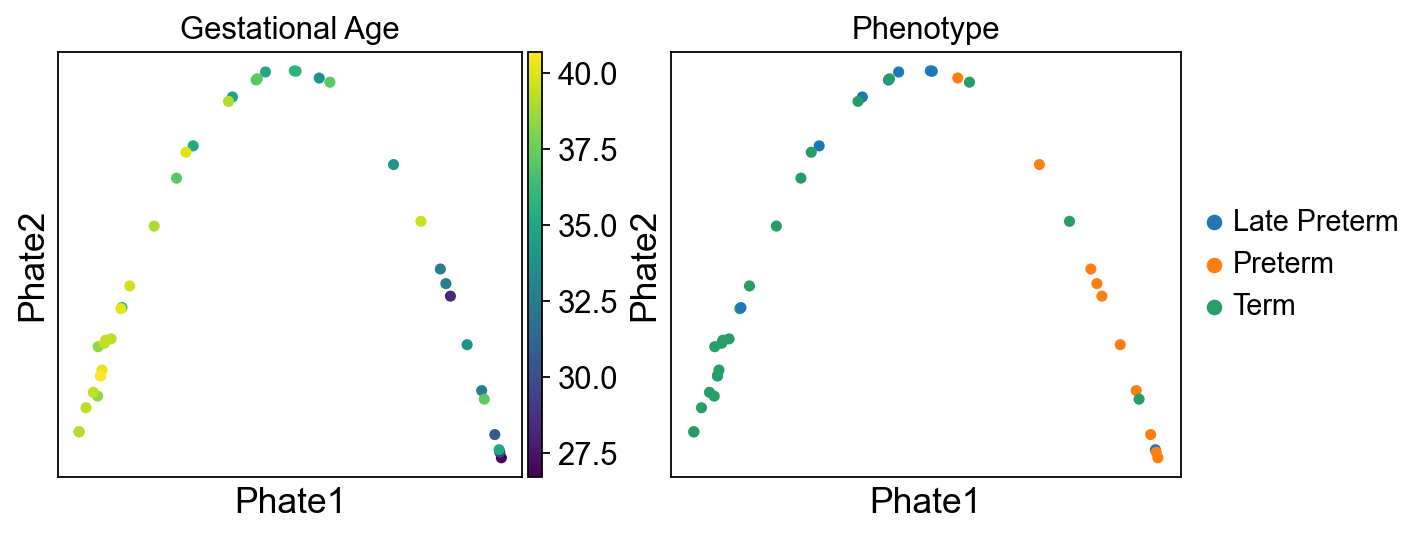

In [10]:
sc.external.tl.phate(adata_sample, n_pca=10, k=9, t="auto",
                     random_state=0, mds_solver="smacof", verbose=True, copy=False)

fig, axes = plt.subplots(1, 2, figsize=(9, 3.5))

sc.external.pl.phate(adata_sample, color=['Gestational.Age'], title="Gestational Age", color_map="viridis", size=100, ax=axes[0], show=False)
sc.external.pl.phate(adata_sample, color=['Category'], title="Phenotype", size=100, ax=axes[1], show=False)

for ax in axes:
    ax.set_xlabel("Phate1", fontsize=16)
    ax.set_ylabel("Phate2", fontsize=16)

plt.show()

### Visualize sample embeddings using diffusion map

/Users/haidyi/Documents/proj/scLKME/.venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


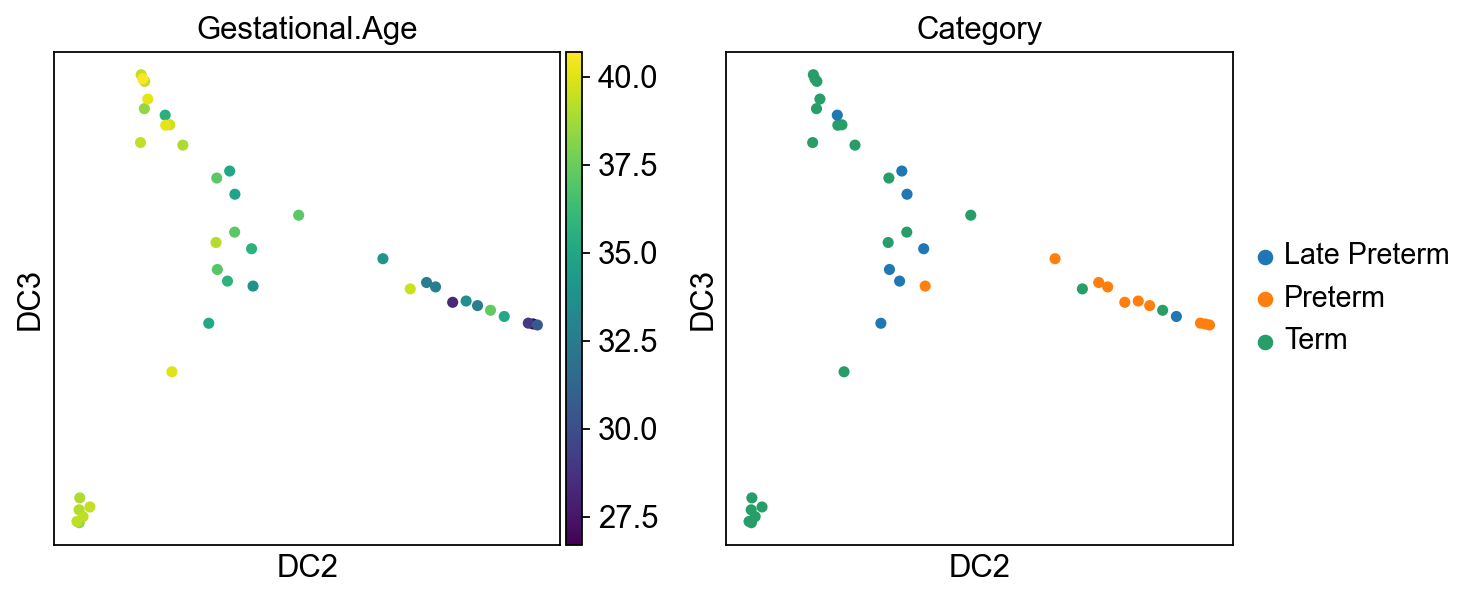

In [11]:
sc.pp.neighbors(adata_sample, n_neighbors=8, use_rep="X", key_added="diffmap_nn")
sc.tl.diffmap(adata_sample, n_comps=3, neighbors_key="diffmap_nn")

sc.pl.diffmap(adata_sample, color=["Gestational.Age", "Category"], size=100,
              palette=sc.pl.palettes.vega_20_scanpy, color_map="viridis", components=['2,3'])

### T-test on the coordinates of diffusion map

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Late Preterm vs. Preterm: Mann-Whitney-Wilcoxon test two-sided, P_val:2.057e-03 U_stat=7.000e+00
Preterm vs. Term: Mann-Whitney-Wilcoxon test two-sided, P_val:5.227e-05 U_stat=2.100e+02
Late Preterm vs. Term: Mann-Whitney-Wilcoxon test two-sided, P_val:9.928e-03 U_stat=1.420e+02


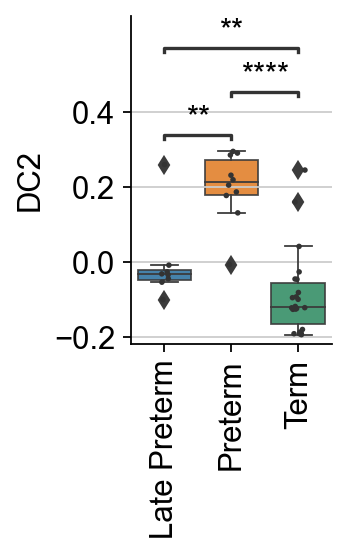

In [12]:
from statannotations.Annotator import Annotator

diffmap_df = sc.get.obs_df(adata_sample, keys=['Category', 'Gestational.Age'], obsm_keys=[('X_diffmap', 1)])

g = sns.catplot(x="Category", y="X_diffmap-1", data=diffmap_df, kind="box",
                legend=False, linewidth=0.8, boxprops=dict(alpha=.9), height=3, aspect=0.8, sharey=False)

axes = g.axes.flatten()
for ax, y in zip(g.axes.flatten(), ["X_diffmap-1"]):
    sns.stripplot(x="Category", y=y, data=diffmap_df, color=".2", size=2.5, jitter=True, ax=ax)
    annot = Annotator(ax, [("Term", "Late Preterm"), ("Late Preterm", "Preterm"), ("Term", "Preterm")],
                      data=diffmap_df, x="Category", y=y, order=["Late Preterm", "Preterm", "Term"])
    annot.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=2)
    annot.apply_test()
    _, test_results = annot.annotate()
    

for ax in axes:
    ax.set_title(None)
    ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=90)

axes[0].set_ylabel("DC2")
axes[0].set_yticks([-0.2, 0.0, 0.2, 0.4])

g.set_xlabels("")

plt.show()